In [ ]:
import h5py
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data_from_hdf5(hdf5_file):
    with h5py.File(hdf5_file, 'r') as h5f:
        for label in h5f.keys():
            group = h5f[label]
            images = [group[key][:] for key in group.keys()]
            labels = [label] * len(images)
            yield images, labels

In [ ]:
def display_images_from_group(hdf5_file, group_name, num_images=5):
    with h5py.File(hdf5_file, 'r') as h5f:
        if group_name in h5f:
            group = h5f[group_name]
            # Collect the specified number of image datasets
            images = [group[key][:] for key in group.keys()][:num_images]
            # Display images
            fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
            for ax, image in zip(axes, images):
                if image.ndim == 2:  # grayscale image
                    ax.imshow(image, cmap='gray')
                else:
                    ax.imshow(image)
                ax.axis('off')
            plt.show()
        else:
            print(f"No group named {group_name} found in the file.")



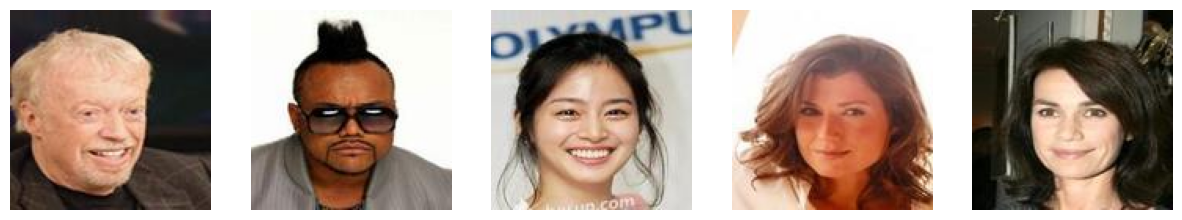

In [ ]:
# Usage example
hdf5_file = '/content/drive/MyDrive/cv_project/train_dataset.hdf5'
group_name = '1'
display_images_from_group(hdf5_file, group_name, num_images=5)

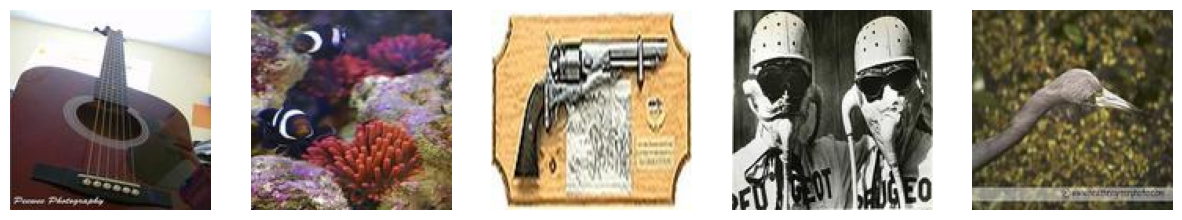

In [ ]:
# Usage example
hdf5_file = '/content/drive/MyDrive/cv_project/train_dataset.hdf5'
group_name = '0'
display_images_from_group(hdf5_file, group_name, num_images=5)

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def compute_integral_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image_normalized = (gray_image - gray_image.min()) / (gray_image.max() - gray_image.min())
    integral_image = np.cumsum(np.cumsum(gray_image_normalized, axis=0), axis=1)
    return integral_image

def sum_region(integral_image, x1, y1, x2, y2):
    total = integral_image[y2 - 1, x2 - 1]
    if x1 > 0:
        total -= integral_image[y2 - 1, x1 - 1]
    if y1 > 0:
        total -= integral_image[y1 - 1, x2 - 1]
    if x1 > 0 and y1 > 0:
        total += integral_image[y1 - 1, x1 - 1]
    return total

def calculate_haar_features(integral_image, x, y, feature_width, feature_height, scale):
    features = []
    # scales = [0.5, 1, 1.5, 2]  # Example scales

    scaled_width = int(feature_width * scale)
    scaled_height = int(feature_height * scale)

    # Horizontal two-rectangle feature
    if x + scaled_width <= integral_image.shape[1] and y + scaled_height <= integral_image.shape[0]:
        width_step = scaled_width // 2
        black = sum_region(integral_image, x, y, x + width_step, y + scaled_height)
        white = sum_region(integral_image, x + width_step, y, x + scaled_width, y + scaled_height)
        features.append(white - black)

    # Vertical two-rectangle feature
    if x + scaled_width <= integral_image.shape[1] and y + scaled_height <= integral_image.shape[0]:
        height_step = scaled_height // 2
        black = sum_region(integral_image, x, y, x + scaled_width, y + height_step)
        white = sum_region(integral_image, x, y + height_step, x + scaled_width, y + scaled_height)
        features.append(white - black)

    # Horizontal three-rectangle feature
    if x + scaled_width <= integral_image.shape[1] and y + scaled_height <= integral_image.shape[0]:
        width_third = scaled_width // 3
        left = sum_region(integral_image, x, y, x + width_third, y + scaled_height)
        middle = sum_region(integral_image, x + width_third, y, x + 2 * width_third, y + scaled_height)
        right = sum_region(integral_image, x + 2 * width_third, y, x + scaled_width, y + scaled_height)
        features.append(white - black)

    # Vertical three-rectangle feature
    if x + scaled_width <= integral_image.shape[1] and y + scaled_height <= integral_image.shape[0]:
        height_third = scaled_height // 3
        top = sum_region(integral_image, x, y, x + scaled_width, y + height_third)
        middle = sum_region(integral_image, x, y + height_third, x + scaled_width, y + 2 * height_third)
        bottom = sum_region(integral_image, x, y + 2 * height_third, x + scaled_width, y + scaled_height)
        features.append(white - black)

    # Four-rectangle feature
    if x + scaled_width <= integral_image.shape[1] and y + scaled_height <= integral_image.shape[0]:
        width_half = scaled_width // 2
        height_half = scaled_height // 2
        top_left = sum_region(integral_image, x, y, x + width_half, y + height_half)
        top_right = sum_region(integral_image, x + width_half, y, x + scaled_width, y + height_half)
        bottom_left = sum_region(integral_image, x, y + height_half, x + width_half, y + scaled_height)
        bottom_right = sum_region(integral_image, x + width_half, y + height_half, x + scaled_width, y + scaled_height)
        features.append(white - black)

    return features

# def load_images_and_labels(image_paths, labels):
#     features_list = []
#     for image_path, label in zip(image_paths, labels):
#         image = cv2.imread(image_path)
#         integral_image = compute_integral_image(image)
#         # Assume a fixed detection window size that you would vary in practice
#         features = calculate_haar_features(integral_image, 0, 0, 24, 24)
#         features_list.append(features)  # Collect specific features
#     return features_list


In [ ]:
def compute_features_from_hdf5(hdf5_file):
    feature_list = []
    with h5py.File(hdf5_file, 'r') as file:
        # Iterate over each group (each label)
        for label in file.keys():
            group = file[label]
            # Iterate over each image in the group
            for image_name in group:
                # Read the image data
                image_data = group[image_name][:]

                # Some HDF5 datasets may store images in a shape (channels, height, width)
                # Convert it to (height, width, channels) if necessary
                if image_data.shape[0] < 4:  # Assuming the image isn't oddly shaped
                    image_data = np.transpose(image_data, (1, 2, 0))

                # Convert image data from numpy array to an image format that OpenCV can use
                image = cv2.cvtColor(image_data, cv2.COLOR_RGB2BGR)

                # Compute the integral image
                integral_image = compute_integral_image(image)

                # Define a region of interest for feature calculation
                x, y = 0, 0
                feature_width, feature_height = integral_image.shape[1] // 2, integral_image.shape[0] // 2

                # Calculate Haar features
                features = calculate_haar_features(integral_image, x, y, feature_width, feature_height, scale = 1)

                # Append (features, label) tuple to the list
                feature_list.append((features, label))

    return feature_list


In [ ]:
import random
train_data = compute_features_from_hdf5('/content/drive/MyDrive/cv_project/train_dataset.hdf5')
random.shuffle(train_data)
X_train = [features for features, label in train_data]
y_train = [label for features, label in train_data]

In [ ]:
test_data = compute_features_from_hdf5('/content/drive/MyDrive/cv_project/test_dataset.hdf5')

X_test = [features for features, label in test_data]
y_test = [label for features, label in test_data]

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(4000, 1000, 4000, 1000)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Create SVM classifier
svm_classifier = SVC(kernel='rbf')  # You can change the kernel and other parameters

# Train the SVM classifier
svm_classifier.fit(X_train[:4000], y_train[:4000])



SVC()

In [ ]:
# Predict on the test set
y_pred = svm_classifier.predict(X_test)

# Print the classification report and accuracy
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.74      0.68       500
           1       0.69      0.58      0.63       500

    accuracy                           0.66      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.66      0.66      0.66      1000

Accuracy: 0.659


In [ ]:
# Get decision function values
decision_scores = svm_classifier.decision_function(X_test)
print("Decision function values:", decision_scores)

Decision function values: [-0.89816213 -0.99676036  0.53407537  0.94593166 -0.72256947 -0.69025215
 -0.2877447  -0.9863082  -0.39510095 -1.08004    -0.93505801 -0.42278139
 -0.68379398 -0.43385741 -0.33903371  1.15870265  0.8413186  -0.91164504
  0.29729367 -0.37245837 -0.61561235 -1.1218578  -0.79545712 -0.98207724
 -0.15493207 -0.81355063 -0.66464108 -0.68442849 -0.51466109 -0.39818921
 -0.37537791 -1.07002919  0.97590953 -0.8853335  -1.01925928 -0.84672952
 -0.28303297 -1.08672338 -0.98475435  0.84707069 -0.06146754 -1.06825402
  0.11333981 -0.81858027 -0.66582719  1.13584098 -1.07957232  0.06335409
 -0.45005215  0.91240905 -1.11957409 -1.00994916 -0.7725564   0.81587352
 -0.78324923 -0.19266031  0.64847966  0.52887363 -1.02443665 -0.37344695
  0.81114159 -0.64405629 -1.10941664 -0.6099896  -1.04508819 -1.11474017
 -0.9737893  -1.0769166  -1.08978896 -0.55698657 -0.96557041 -0.89400016
 -0.39025895 -1.09225597 -0.44688775 -0.25347268 -0.97679256 -1.06684531
 -1.12711208 -0.41236924 

In [ ]:
y_pred[:5], decision_scores[:5]

(array(['0', '0', '1', '1', '0'], dtype='<U1'),
 array([-0.89816213, -0.99676036,  0.53407537,  0.94593166, -0.72256947]))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create AdaBoost classifier with a decision tree as base estimator
# Let's use a decision tree with max_depth=1 (a stump) as the weak classifier
base_estimator = DecisionTreeClassifier(max_depth=1)
ada_boost_classifier = AdaBoostClassifier(estimator=base_estimator, n_estimators=150, learning_rate=1.0, random_state=42)

# Train the AdaBoost model
ada_boost_classifier.fit(X_train, y_train)
# Predict the response for test dataset
y_pred = ada_boost_classifier.predict(X_test)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.64      0.70      0.67       500
           1       0.67      0.60      0.63       500

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.65      0.65      0.65      1000

Accuracy: 0.649


              precision    recall  f1-score   support

           0       0.59      0.69      0.64       581
           1       0.65      0.56      0.60       619

    accuracy                           0.62      1200
   macro avg       0.62      0.62      0.62      1200
weighted avg       0.62      0.62      0.62      1200



/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


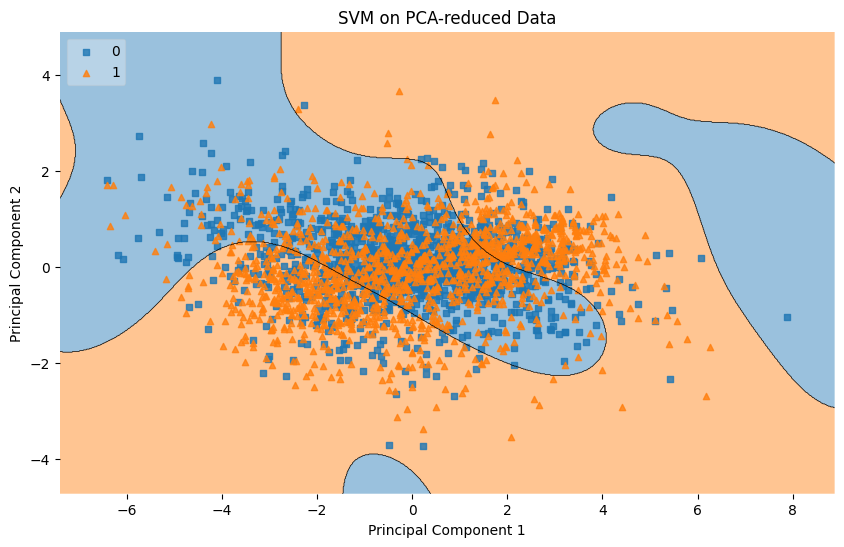

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions

# Assume X_train and y_train are defined as per your dataset
X, y = np.array(X_train), np.array(y_train)

# Step 1: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Reduce dimensionality with PCA
pca = PCA(n_components=2)  # Reduce to 2D for visualization
X_pca = pca.fit_transform(X_scaled)

# Step 3: Split the data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_pca, y, test_size=0.3, random_state=42)
y_train1 = y_train1.astype(np.int_)
# Step 4: Train SVC
model = SVC(kernel='rbf')
model.fit(X_train1, y_train1)
y_test1 = y_test1.astype(np.int_)

# Predict on the test set
y_pred = model.predict(X_test1)
y_pred = y_pred.astype(np.int_)

# Print the classification report and accuracy
print(classification_report(y_test1, y_pred))
# Step 5: Plot decision regions
plt.figure(figsize=(10, 6))
plot_decision_regions(X_train1, y_train1, clf=model, legend=2, scatter_kwargs={'s': 20, 'edgecolor': None, 'cmap': plt.cm.Pastel1})

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM on PCA-reduced Data')
plt.show()


<ipython-input-58-a9bbe74caadb>:47: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.coolwarm, s=20)


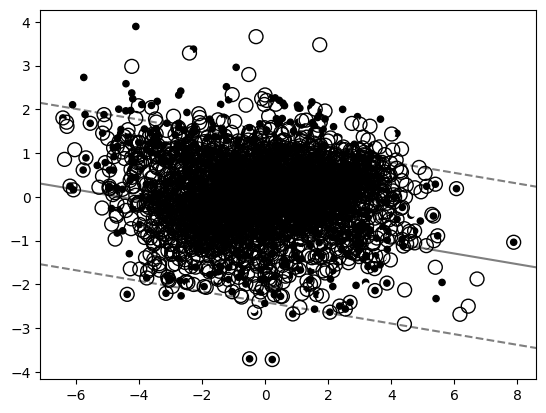

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)

    # Plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # Plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
                   linewidth=1, facecolors='none', edgecolors='k')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# X, y = np.array(X_train), np.array(y_train)
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Train SVC
model = SVC(kernel='rbf')
model.fit(X_train1, y_train1)

# # Plot decision regions
# plt.figure(figsize=(10, 6))
# plot_decision_regions(X_train, y_train, clf=model, legend=2)
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('SVM on PCA-reduced Data')
# plt.show()
# Plot data and decision boundary
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.coolwarm, s=20)
plot_svc_decision_function(svm_classifier)
plt.show()


<ipython-input-42-48503197f982>:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')


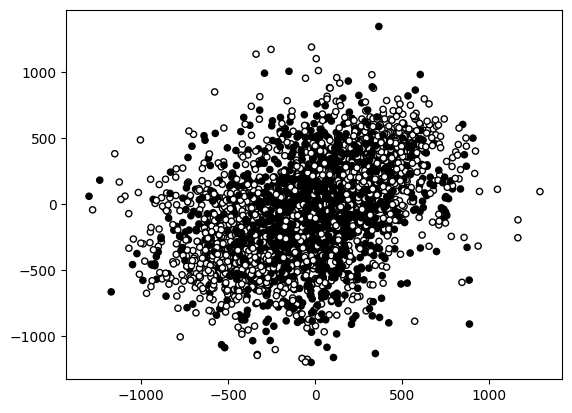

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')


In [ ]:
import pandas as pd
# Convert data to DataFrame
df = pd.DataFrame([features for features, _ in train_data], columns=[
    'Horizontal two-rectangle',  # Provide names here
    'Vertical two-rectangle',
    'Horizontal three-rectangle',
    'Vertical three-rectangle',
    'Four-rectangle feature'
])

# Add the labels
df['Label'] = [label for _, label in train_data]
df.head()

,Horizontal two-rectangle,Vertical two-rectangle,Horizontal three-rectangle,Vertical three-rectangle,Four-rectangle feature,Label
0,31.921569,-873.388235,-873.388235,-873.388235,-873.388235,0
1,-275.460630,-78.271654,-78.271654,-78.271654,-78.271654,0
2,-339.192157,-448.627451,-448.627451,-448.627451,-448.627451,0
3,-464.752941,-304.274510,-304.274510,-304.274510,-304.274510,0
4,133.128631,153.087137,153.087137,153.087137,153.087137,0


In [ ]:
df.min(), df.max()

(Horizontal two-rectangle     -1300.507874
 Vertical two-rectangle       -1198.768627
 Horizontal three-rectangle   -1198.768627
 Vertical three-rectangle     -1198.768627
 Four-rectangle feature       -1198.768627
 Label                                   0
 dtype: object,
 Horizontal two-rectangle      1294.145669
 Vertical two-rectangle         1344.85098
 Horizontal three-rectangle     1344.85098
 Vertical three-rectangle       1344.85098
 Four-rectangle feature         1344.85098
 Label                                   1
 dtype: object)

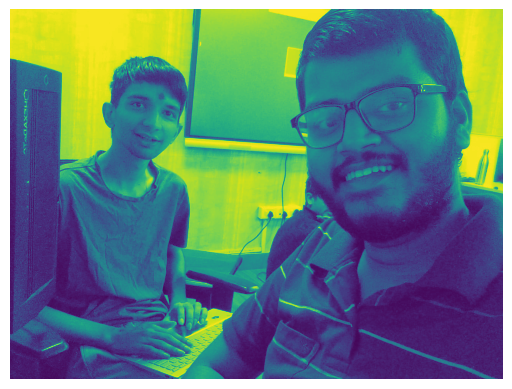

{'horizontal_two_rectangle_0.5': -0.1882352941176464,
 'vertical_two_rectangle_0.5': -0.25098039215686185,
 'horizontal_three_rectangle_0.5': -47.1843137254902,
 'vertical_three_rectangle_0.5': -47.27843137254905,
 'four_rectangle_0.5': -0.06274509803921546,
 'horizontal_two_rectangle_1': -3.2235294117646163,
 'vertical_two_rectangle_1': -2.086274509804184,
 'horizontal_three_rectangle_1': -187.20784313725505,
 'vertical_three_rectangle_1': -187.2705882352941,
 'four_rectangle_1': -1.207843137255054,
 'horizontal_two_rectangle_1.5': -6.145098039215554,
 'vertical_two_rectangle_1.5': -7.89411764705892,
 'horizontal_three_rectangle_1.5': -425.4156862745099,
 'vertical_three_rectangle_1.5': -421.29019607843213,
 'four_rectangle_1.5': -2.2313725490193974,
 'horizontal_two_rectangle_2': -5.694117647059102,
 'vertical_two_rectangle_2': -8.43137254902058,
 'horizontal_three_rectangle_2': -750.7843137254897,
 'vertical_three_rectangle_2': -755.1607843137242,
 'four_rectangle_2': 0.070588235294

In [ ]:
image = cv2.imread('/content/pic.jpg')
# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Display the image with detected faces using matplotlib
plt.imshow(gray_image)
plt.axis("off") # Turn off axis numbers and ticks
plt.show()

integral_image = compute_integral_image(image)
# Assume a fixed detection window size that you would vary in practice
features = calculate_haar_features(integral_image, 0, 0, 24, 24)
features